# classification_human_horse_images_CNN



In [2]:
### installing required packages
#pip install matplotlib
#pip install tensorflow

In [3]:
#importig required packages

import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Dataset

I use the `Horse or Human dataset`, which contains images of horses and humans.

Download the `training` and `validation` sets by running the cell below:

In [4]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [5]:

# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Now take a look at a sample image of each one of the classes:

Sample horse image:


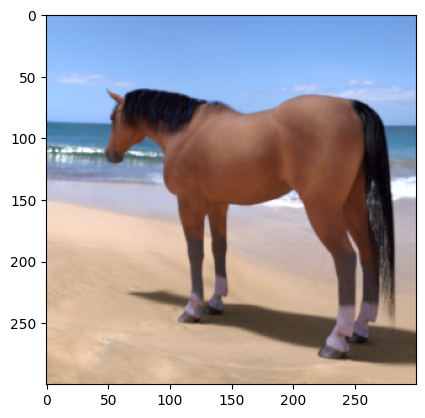


Sample human image:


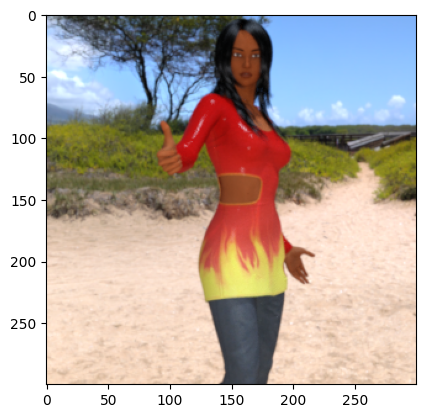

In [6]:

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[7])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[8])}"))
plt.show()

In [7]:

# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


## Training and Validation Generators

he images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [8]:

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator: tuple containing the generators
  """
  train_datagen =  ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))


  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )


  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [9]:


# Test  generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


**Expected Output:**
```
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
```

## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [10]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-02 13:53:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  29.3MB/s    in 2.9s    

2023-10-02 13:53:07 (29.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [11]:
  from tensorflow.keras.applications.inception_v3 import InceptionV3
  from tensorflow.keras import layers

In [12]:

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [13]:

def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
   layer.trainable = False



  return pre_trained_model

In [14]:

pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

**Expected Output:**
```
batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0]
__________________________________________________________________________________________________
mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
                                                                activation_276[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
                                                                activation_280[0][0]             
__________________________________________________________________________________________________
activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0]
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
                                                                mixed9_1[0][0]                   
                                                                concatenate_5[0][0]              
                                                                activation_281[0][0]             
==================================================================================================
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784


```

In [15]:


total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

## Creating callbacks for later



In [16]:


# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## Pipelining the pre-trained model



In [17]:

def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

Check that everything works as expected:

In [18]:

last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


**Expected Output (if `mixed7` layer was used):**
```
last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
```

In [19]:

def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense  (1, activation='sigmoid')(x)
  model = Model(pre_trained_model.input, x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE

  return model

In [20]:
# grader-required-cell

# Save  model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


**Expected Output:**
```
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.
```

In [ ]:
# Running model
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

The training should have stopped after less than 10 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!
:

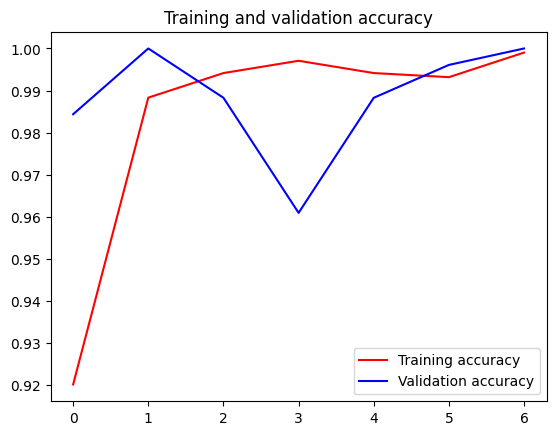

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()